# Big Data Analytics Homework
##GUENFOUD fayçal
##SEBAA Abderahim

#I Working Environement
In order to use spark in collab VM we should first download it and istall it

##b) Installing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

from sklearn.datasets import make_blobs

##c) Installing Spark

In [ ]:
# Installing Java (because spark runs on java)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# Downloading Spark
!wget https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

--2022-03-30 19:49:54--  https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300971569 (287M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop3.2.tgz’

spark-3.2.1-bin-had 100%[===================>] 287.03M   240MB/s    in 1.2s    

2022-03-30 19:49:55 (240 MB/s) - ‘spark-3.2.1-bin-hadoop3.2.tgz’ saved [300971569/300971569]



In [ ]:
# Extracting the downloaded file
!tar -xf spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 198 kB 44.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=d5851c8941b0718016cbad03e76b8cf1f413927b32dee23015b1a8c5d0a17b15
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
# Adding env variables
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

#importing spark
import findspark

findspark.init("spark-3.2.1-bin-hadoop3.2")

In [ ]:
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages org.apache.spark:spark-avro_2.12:3.2.0 pyspark-shell"

##d) Spark Context
> Here we'll create the SparkContext to init our app as a driver and synch it with the worker nodes

In [ ]:
from pyspark import SparkContext, SparkConf

configuration = SparkConf().setAppName("name").setMaster("local[3]")
sc = SparkContext(conf=configuration)

##e) Spark Session
>Here we'll create a SparkSession in order to use Spark SQL

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.config(conf=configuration).getOrCreate()

#II Data

##a) Generating the data

In [ ]:
# a data frame of 50000 smaples, 2 features and 3 classes

samples,y = make_blobs(n_samples=50000,n_features=2,centers=3)

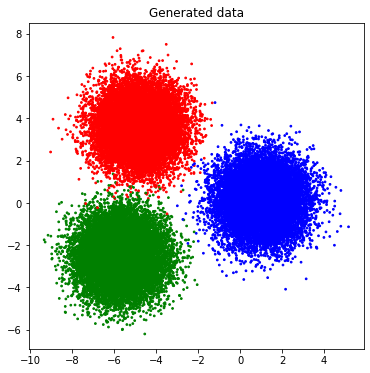

In [ ]:
plot_2D(samples,y,"Generated data")

##b) Creating the RDD
> By creating an RDD, we asure a distribution of our data into different worker nodes that would do the transformations seperatly.

In [ ]:
# Appending all the samples into a list of tuples
tuples = []
for features,label in zip(samples,y):
  tuples.append((features[0],features[1],label))


In [ ]:
# Parallelizing the list to create a rdd
rdd = sc.parallelize(tuples)

##c) Transfroming the elements into Rows

In [ ]:
from pyspark.sql import Row
# Here we cast the elements so it can be compatible with the spark data frame types
rdd1 = rdd.map(lambda line : Row(x=float(line[0]),y=float(line[1]),label=int(line[2])))
rdd1.take(6)

[Row(x=-4.599777692206298, y=-2.1657233032218626, label=1),
 Row(x=0.26107695832100575, y=0.19662262055378235, label=2),
 Row(x=1.5591884994616725, y=0.22805724892608614, label=2),
 Row(x=-4.635160093224742, y=-3.46607429320618, label=1),
 Row(x=-3.0305368356387534, y=-2.488656418988299, label=1),
 Row(x=-6.292250507862864, y=-0.7478058200831124, label=1)]

##d) Creating a pyspark DataFrame from the RDD

In [ ]:
sparkDF = rdd1.toDF()
sparkDF.show(10)

+-------------------+-------------------+-----+
|                  x|                  y|label|
+-------------------+-------------------+-----+
| -4.599777692206298|-2.1657233032218626|    1|
|0.26107695832100575|0.19662262055378235|    2|
| 1.5591884994616725|0.22805724892608614|    2|
| -4.635160093224742|  -3.46607429320618|    1|
|-3.0305368356387534| -2.488656418988299|    1|
| -6.292250507862864|-0.7478058200831124|    1|
| -5.396774363649289|  3.644335621246449|    0|
|-0.7408652469747914|-2.2284988730600217|    2|
| -5.985295763373964|-2.1814822019044255|    1|
| 1.3349466008034945|0.48140366256488254|    2|
+-------------------+-------------------+-----+
only showing top 10 rows



## **e) Resampling**

In [ ]:
from sklearn.preprocessing import LabelEncoder
def plot_2D(data_matrix, labels=None, title=''):
  '''
    A function that plots our data clusters in 2D dimensions
  '''
  colors_init = ['red', 'green', 'blue', 'yellow', 'purple']
  nb_labels = len(np.unique(labels))
  if labels is not None:
    int_labels = LabelEncoder().fit_transform(labels)
    colors = [colors_init[i] for i in range(nb_labels)]
    c = [colors[i] for i in int_labels]
  else:
    c = 'tab:blue'

  fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
  ax1.scatter(data_matrix[:, 0], data_matrix[:, 1], s=3, c=c)
  ax1.set_title(title)

  plt.show()

In [ ]:
import plotly.express as px
def plot_3D(data_matrix, labels=None, title=''):
  '''
    A function that plots our data clusters in 3D dimensions
  '''
  colors_init = ['red', 'green', 'blue', 'yellow', 'purple']
  nb_labels = len(np.unique(labels))
  if labels is not None:
    int_labels = LabelEncoder().fit_transform(labels)
    colors = ['red', 'green', 'blue']
    colors = [colors_init[i] for i in range(nb_labels)]
    c = [colors[i] for i in int_labels]
  else:
    c = 'tab:blue'

  fig = px.scatter_3d(
      data_matrix, data_matrix[:, 0], data_matrix[:, 1], data_matrix[:, 2],
      color=c,labels={'color': "labels"})
  fig.update_traces(marker_size=8)
  fig.show()

> **Adding more points**

In [ ]:
samples2,y2 = make_blobs(n_samples=100000,n_features=2,centers=3)

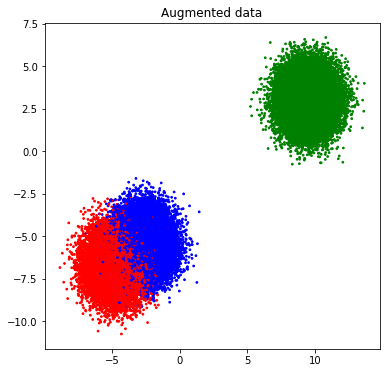

In [ ]:
plot_2D(samples2,y2,"Augmented data")

> **Adding more dimensions**

In [ ]:
samples3,y3 = make_blobs(n_samples=50000,n_features=3,centers=3)

In [ ]:
plot_3D(samples3,y3,"Augmented dimension")

#III Analyse descriptive

##a) Verification of the number of classes
Here we can see that there's 3 distinct classes in our table

In [ ]:
sparkDF.select("label").distinct().show()

+-----+
|label|
+-----+
|    0|
|    1|
|    2|
+-----+



## b) Verification of the number of points
The number of lines in our DataFrame is equal to the number of samples we generated

In [ ]:
sparkDF.count()

50000

## c) Variance of classes
In this case we'll use an SQL Query to get the request by creating a table

In [ ]:
sparkDF.createOrReplaceTempView("SparkDF")
query = spark.sql("SELECT VARIANCE(label) FROM SparkDF")
query.show()

+------------------+
|   variance(label)|
+------------------+
|0.6666733330666603|
+------------------+



#IV Clustering with available methodes

## a) Using Sklearn
In this part we'll init a k-means++ which is a smarter way to initialize the centroids in a way it maximizes the distances between the centroids

In [ ]:
# Importing Kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
import time

# Init starting time
start_time = time.time()
# Init Kmeans
kmeans = KMeans(n_clusters=3,init="k-means++")
# CLustering
kmeans.fit(samples)

# Computing execution time
exec_time = time.time() - start_time
print("Clustering using Sklearn execution time : {} seconds".format(exec_time))



Clustering using Sklearn execution time : 0.3265402317047119 seconds


In [ ]:
labels_pred = kmeans.labels_
np.unique(labels_pred)

array([0, 1, 2], dtype=int32)

In [ ]:
print("NMI Score for Sklearn KMeans : {}".format(normalized_mutual_info_score(y,labels_pred)))

NMI Score for Sklearn KMeans : 0.9930266390698393


**The result express a good/perfect clustering which is normal since we have a large inetrclass variance**

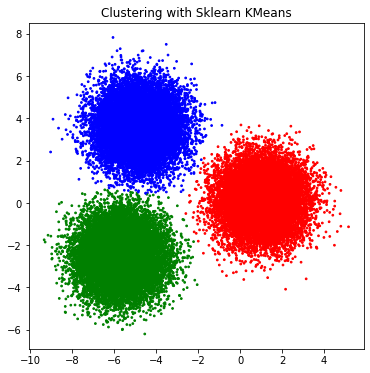

In [ ]:
plot_2D(samples,labels_pred,"Clustering with Sklearn KMeans")

## **b) Using MLlib**

In [ ]:
# Importing mllib modules for Kmeans
from pyspark.ml.clustering import KMeans as KMeans_ml
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

**We extract our feature columns in order to fit the kmeans model**

In [ ]:
# Extracting the features
vec_assembler = VectorAssembler(inputCols = sparkDF.columns[0:2], outputCol='features')
final_data = vec_assembler.transform(sparkDF)

# Init Start Time
start_time = time.time()
kmeans = KMeans_ml().setK(3).setSeed(1)
model = kmeans.fit(final_data)

# Computing execution time
exec_time = time.time() - start_time
print("Clustering using Sklearn execution time : {} seconds".format(exec_time))


Clustering using Sklearn execution time : 4.440206050872803 seconds


Here ze notice that the execution time of kmeans is slower than the execution time using sklearn because of the communication time of data from the different worker nodes and the driver

**We extract the prediction column as a list in order to compute the NMI and plot the results**

In [ ]:
r = model.transform(final_data)
labels_pred_mlib = [row.prediction for row in r.collect()]
labels_pred_mlib[0:5]

[1, 2, 2, 1, 1]

In [ ]:
print("NMI Score for MLlib KMeans : {}".format(normalized_mutual_info_score(y,labels_pred_mlib)))

NMI Score for MLlib KMeans : 0.9930266390698393


**The result express a good clustering which is normal since we have a large inetrclass variance**

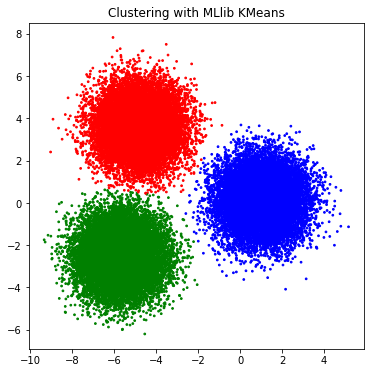

In [ ]:
plot_2D(samples,labels_pred_mlib,"Clustering with MLlib KMeans")

#V Implementation of K-means

##**a) Compute Centroids**

In [ ]:
def compute_centroids(points,cluster_ids):
  # Zip two RDDs into one
  rdd_zipped = cluster_ids.zip(points)

  # Sum the points by their cluster ids
  # We turn our elements into np.array to easily hnandle multidimentionality
  sum_by_cluster_id = rdd_zipped.reduceByKey(lambda x,y : np.array(x)+np.array(y))

  # count the points by their cluster ids
  rdd_zipped_copy = rdd_zipped
  rdd_zipped_copy=rdd_zipped_copy.mapValues(lambda x : 1)
  count_by_cluster_id=rdd_zipped_copy.reduceByKey(lambda x,y : x+y)

  # Sorting to fasten the lookup
  count_by_cluster_id = count_by_cluster_id.sortByKey()

  mean_tuples = []
  for ts in sum_by_cluster_id.collect():
    sum = ts[1]
    count = count_by_cluster_id.lookup(ts[0])[0]
    mean = np.around((sum/count), decimals=2)
    mean_tuples.append((ts[0],mean))
  return sc.parallelize(mean_tuples)

> **Trying the function with one dimension points**

In [ ]:
points = sc.parallelize([1.3,2.4,2.0,5.0,4.7,2.2])
cls_ids = sc.parallelize(["a","b","a","b","a","b"])
compute_centroids(points,cls_ids).collect()

[('b', 3.2), ('a', 2.67)]

> **Trying the function with two dimension points** 

In [ ]:
points = sc.parallelize([(1,1.3),(2,2.4),(1,2.0),(3,5.0),(3,4.7),(2,2.2)])
cls_ids = sc.parallelize(["a","b","a","b","a","b"])
compute_centroids(points,cls_ids).collect()

[('b', array([2.33, 3.2 ])), ('a', array([1.67, 2.67]))]

> **We can see that our function handles multidimensionality without additional parameters**

##**b) Assign Clusters**

> **i - Computing the squared distances between a point and a list of centroids**

In [ ]:
def squared_distances(point,centers):
  squared_distances = []
  for center in centers:
    distance = euclidean(np.array(point),np.array(center))
    squared_distance = np.around(distance**2, decimals=2)
    squared_distances.append(squared_distance)
  return squared_distances


In [ ]:
squared_distances((2,2.4),[[2.33, 3.2],[1.67, 2.67]])

[0.75, 0.18]

> **To collect all the means of the centroids RDD, we suppose that the driver is large enough to handle all the distributed data**

In [ ]:
def assign_clusters(points, centroids):
  # ii - Collect all the centroids as a list
  list_centroids = centroids.map(lambda t : t[1]).collect() # We suppose that driver's size >> distributed data

  # iii - Assigne each point to a class
  classes = points.map(lambda p : np.argmin(squared_distances(p,list_centroids)))
  return classes

## **c) Clustering using the implemented functions**

In [ ]:
# Creating RDD from the generated samples
points = sc.parallelize(samples)
cluster_ids = sc.parallelize(y)

# Init Start Time
start_time = time.time()

# Computing centroids
centroids = compute_centroids(points,cluster_ids)

# Clustering the samples
labels_pred_rdd = assign_clusters(points,centroids)

# Computing execution time
exec_time = time.time() - start_time
print("Clustering using Sklearn execution time : {} seconds".format(exec_time))

Clustering using Sklearn execution time : 1.0240378379821777 seconds


> **Evaluation of the implemented kmeans**

In [ ]:
labels_pred_imp = labels_pred_rdd.collect()
print("NMI Score for Sklearn KMeans : {}".format(normalized_mutual_info_score(y,labels_pred_imp)))

NMI Score for Sklearn KMeans : 0.9930266390698393


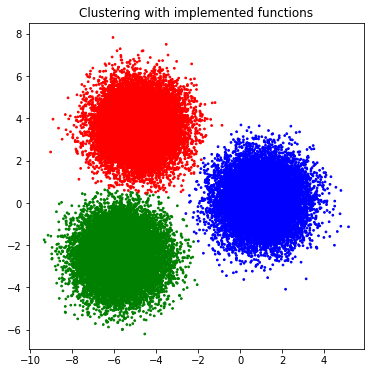

In [ ]:
plot_2D(samples,labels_pred_imp,"Clustering with implemented functions")

## **d) interpretation:**
Overall, the 3 methodes gives us the same clustering performance with the used samples (even though it's an easy sample since the amount of data is not too arge and the interclass variance is large)

But when it comes to the execution time, we cans see a difference in performance such as the sklearn implementation gives the best performance followed by the implemented function, then comes the MLlib function at the end since it consumed the largest amount of time to cluster our data